In [75]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [6]:
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder

## Load data

In [9]:
for file_name in os.listdir("files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join("files", file_name)

        df_name = os.path.splitext(file_name)[0]
        globals()[df_name] = pd.read_csv(file_path)


## SANITY CHECK

In [137]:
#NO MISTAKE IN RETIREES CLASSIFICATION ?

ids_1 = set(learn_dataset_retired_pension["PRIMARY_KEY"])
ids_2 = set(learn_dataset_retired_jobs["PRIMARY_KEY"])
ids_3 = set(learn_dataset_retired_former["PRIMARY_KEY"])

# Step 2: Check the equality of the IDs between datasets
def check_sanity(ids_a, ids_b, dataset_a, dataset_b):
    if ids_a == ids_b:
        print(f"Sanity check passed: {dataset_a} and {dataset_b} contain the same individuals.")
    else:
        print(f"Sanity check failed: There are differences in the individuals from {dataset_a} and {dataset_b}")

check_sanity(ids_1, ids_2, "Dataset 1", "Dataset 2")
check_sanity(ids_1, ids_3, "Dataset 1", "Dataset 3")
check_sanity(ids_2, ids_3, "Dataset 2", "Dataset 3")

not_common_ids_1 = ids_1.symmetric_difference(ids_3)
print(f"Number of people that are not common to dataset 1 and 3: {len(not_common_ids_1)}")

not_common_ids_2 = ids_2.symmetric_difference(ids_3)
print(f"Number of people that are not common to dataset 2 and 3: {len(not_common_ids_2)}")

print("These individuals are in dataset3 but not in dataset1:", ids_3 - ids_1)
print("These individuals are in dataset3 but not in dataset2:", ids_3 - ids_2)

#We are OK, it just that the the dataset 3 has more data. 


Sanity check passed: Dataset 1 and Dataset 2 contain the same individuals.
Sanity check failed: There are differences in the individuals from Dataset 1 and Dataset 3
Sanity check failed: There are differences in the individuals from Dataset 2 and Dataset 3
Number of people that are not common to dataset 1 and 3: 2083
Number of people that are not common to dataset 2 and 3: 2083
These individuals are in dataset3 but not in dataset1: {16389, 40966, 8202, 32783, 32784, 8207, 65556, 40989, 40996, 8231, 24621, 8238, 16438, 90170, 32835, 24656, 41044, 41047, 41051, 82011, 32862, 41054, 41056, 41058, 41065, 41067, 73841, 73842, 41078, 90232, 8318, 24707, 90245, 138, 90253, 16528, 49318, 82092, 8369, 24754, 90293, 16571, 49340, 82111, 195, 204, 210, 65749, 57559, 41178, 98525, 49386, 65772, 57589, 98550, 24833, 262, 263, 82184, 65803, 49421, 82189, 82192, 8467, 82197, 310, 82237, 8511, 33090, 74051, 16713, 57680, 24918, 57695, 8544, 33122, 74085, 358, 16743, 362, 41323, 57709, 90488, 90489, 57

## Simplification of categories

In [11]:
# sports
learn_dataset_sport = pd.merge(learn_dataset_sport, code_Sports, left_on="Sports", right_on="Code")
learn_dataset_sport["Sports_Category"] = learn_dataset_sport["Categorie"]
learn_sports = learn_dataset_sport[["PRIMARY_KEY", "Sports_Category"]]

# departments into regions
def merge_and_extract_region(df, merge_column, region_column_name):
    df = pd.merge(df, departments, left_on=merge_column, right_on="DEP")
    df[region_column_name] = df["REG"]
    df.drop(["Nom du département", "REG", "DEP", merge_column], axis=1, inplace=True)
    return df


learn_dataset_job = merge_and_extract_region(
    learn_dataset_job, merge_column="JOB_DEP", region_column_name="REG_JOB"
)

learn_dataset_retired_jobs = merge_and_extract_region(
    learn_dataset_retired_jobs, merge_column="JOB_DEP", region_column_name="REG_JOB"
)

learn_dataset_retired_jobs = merge_and_extract_region(
    learn_dataset_retired_jobs, merge_column="FORMER_DEP", region_column_name="REG_FORMER"
)

In [13]:
#Economic sector into fewer categories (and numeric instead of object/string)
def sector_mapping(nace_code):
    if nace_code == "AZ":  
        return "Agriculture, forestry and fishing)"
    elif "BZ" <= nace_code <= "EZ":
        return "Manufacturing, mining and quarrying and other industrial activities"
    elif nace_code == "FZ": 
        return "Construction"
    elif "GZ" <= nace_code <= "IZ":  
        return "Wholesale and retail trade, transportation and storage, accommodation and food service activities"
    elif "JA" <= nace_code <= "JC":
        return "Information and communication"
    elif nace_code == "KZ": 
        return "Financial and insurance activities"
    elif nace_code == "LZ": 
        return "Real estate activities"
    elif "MA" <= nace_code <= "NZ":
        return "Professional, scientific, technical, administrative and support service activities"
    elif "OZ" <= nace_code <= "QB":
        return "Public administration and defence, education, human health and social work activities"
    elif "RZ" <= nace_code <= "UZ":
        return "Other services activities"
    else:
        return "Unknown Sector"

code_Economic_sector["Nomenclature"] = code_Economic_sector["Code"].map(sector_mapping)
code_Economic_sector["Economic_sector_num"] = pd.factorize(code_Economic_sector["Nomenclature"])[0] + 1

#code_emp_contract["emp_contract_num"] = pd.factorize(code_emp_contract["Code"])[0] + 1
code_HIGHEST_CREDENTIAL["HIGHEST_CREDENTIAL_num"] = pd.factorize(code_HIGHEST_CREDENTIAL["Code"])[0] + 1
code_act["act_num"] = pd.factorize(code_act["Code"])[0] + 1

#learn_dataset_emp_contract = pd.merge(learn_dataset_emp_contract, code_emp_contract, left_on="emp_contract",  right_on="Code")
#learn_dataset_emp_contract.drop(["Code", "Libellé"], axis=1, inplace=True)
#replace this with one-hot-encoding

## Merging

In [16]:
learn_data = learn_dataset
learn_data = learn_data[['target'] + [col for col in learn_data.columns if col != 'target']]

learn_data = pd.merge(learn_data, code_act, left_on="act", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé"], axis=1, inplace=True)
learn_data = pd.merge(learn_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

learn_data = pd.merge(learn_data, city_pop, on="INSEE_CODE", how="left")
learn_data = pd.merge(learn_data, city_loc, on="INSEE_CODE", how="left")

In [18]:
learn_dfs = [learn_dataset_emp_contract, learn_dataset_job, learn_dataset_retired_former, learn_dataset_retired_jobs, learn_dataset_retired_pension, learn_sports]

for df in learn_dfs:
    learn_data = pd.merge(learn_data, df, on="PRIMARY_KEY", how="outer")

In [20]:
def combine_columns(col_x, col_y):
    return col_x.fillna(col_y) if col_y is not None else col_x

for column in learn_data.columns:
    if column.endswith('_x'):
        base_column = column[:-2]  # Remove `_x` suffix
        y_column = base_column + '_y'
        if y_column in learn_data.columns:
            # Combine the columns
            learn_data[base_column] = combine_columns(learn_data[column], learn_data[y_column])
            # Drop the original `_x` and `_y` columns
            learn_data = learn_data.drop(columns=[column, y_column])


## Formatting

In [23]:
def household_num(value):
    parts = value.split('|')  # Split the value by '|'
    if parts[1] in {'1', '2', '3'}:  # For M|1|-- to M|3|--
        return int(parts[1])
    elif parts[1] == '4':  # For M|4|1 to M|4|4
        return 4 + (int(parts[2]) - 1)  # 4 + (1-1), 4 + (2-1), etc.
    return None  # Handle unexpected cases gracefully

code_HOUSEHOLD_TYPE['HOUSEHOLD_TYPE_num'] = code_HOUSEHOLD_TYPE['Code'].apply(household_num)
learn_data['HOUSEHOLD_TYPE'] = learn_data['HOUSEHOLD_TYPE'].apply(household_num)


In [25]:
#learn_data["JOB_42"] = learn_data["JOB_42"].str.extract(r'csp_(\d)')[0].astype(int)
#learn_data["FORMER_JOB_42"] = learn_data["FORMER_JOB_42"].str.extract(r'csp_(\d)')[0].astype("Int64")
learn_data["employee_count"] = learn_data["employee_count"].str.extract(r'tr_(\d)')[0].astype("Int64")
learn_data["Employer_category"] = learn_data["Employer_category"].str.extract(r'ct_(\d)')[0].astype("Int64")

learn_data = pd.merge(learn_data, code_Economic_sector, left_on="Economic_sector", right_on="Code", how="left")

learn_data = pd.merge(learn_data, code_work_description_map, left_on="work_description", right_on="N3", how="left")
learn_data.drop(["work_description", "N3", "N2"], axis=1, inplace=True)
learn_data["N1"] = learn_data["N1"].str.extract(r'csp_(\d)')[0].astype("Int64")
learn_data.rename(columns={"N1": "work_description"}, inplace=True)

learn_data["emp_contract"] = combine_columns(learn_data["emp_contract"], learn_data["former_emp_contract"])
learn_data["Pay"] = combine_columns(learn_data["Pay"], learn_data["RETIREMENT_PAY"])
#learn_data['is_retired'] = (learn_data['JOB_42'] == 7).astype(int)
#learn_data['is_unemployed'] = (learn_data['act'].str.startswith('TACT2_') & (learn_data['act'] != 'TACT2_1')).astype(int)
#learn_data['is_unemployed'] = (learn_data['act'] == 'TACT1_2').astype(int)

In [27]:
def categorize_retirement_age():
    global learn_data  # Modify the global learn_data DataFrame
    
    # Ensure the retirement_age column is numeric
    learn_data['retirement_age'] = pd.to_numeric(learn_data['retirement_age'], errors='coerce')
    
    # Define the bins and corresponding labels
    bins = [0, 57, 60, 61, 63, 65, float('inf')]  # Specify edges for the ranges
    labels = ['<57', '57-59', '60', '61-62', '63-64', '65+']  # Labels for ranges

    # Initial categorization with pd.cut
    learn_data['retirement_age_cat'] = pd.cut(
        learn_data['retirement_age'], 
        bins=bins, 
        labels=labels, 
        right=False,  # Left-closed intervals
        include_lowest=True
    )


    # Ensure missing values in retirement_age_cat are handled properly
    learn_data['retirement_age_cat'] = learn_data['retirement_age_cat'].astype(object)  # Avoid ambiguity with NA
    
    # Handle exact matches for 60 and 65
    learn_data.loc[learn_data['retirement_age'] == 60, 'retirement_age_cat'] = '60'

# Call the function
categorize_retirement_age()

In [29]:
# types
learn_data["sex"] = pd.factorize(learn_data["sex"])[0]
learn_data["studying"] = learn_data["studying"].astype("int64")
#or learn_data["Sports_Category"] = pd.to_numeric(learn_data["Sports_Category"], errors='coerce').astype("Int64")
learn_data["Sports_Category"] = learn_data["Sports_Category"].fillna(0).astype("int64")
learn_data["REG_JOB"] = pd.to_numeric(learn_data["REG_JOB"], errors='coerce').astype('Int64')
learn_data["REG_FORMER"] = pd.to_numeric(learn_data["REG_FORMER"], errors='coerce').astype('Int64')
learn_data["retirement_age"] = pd.to_numeric(learn_data["retirement_age"], errors='coerce').astype('Int64')
learn_data["WORKING_HOURS"] = pd.to_numeric(learn_data["WORKING_HOURS"], errors='coerce').astype('Int64')
learn_data["Economic_sector_num"] = pd.to_numeric(learn_data["Economic_sector_num"], errors='coerce').astype('Int64')
learn_data["Pay"] = pd.to_numeric(learn_data["Pay"], errors='coerce').astype('Int64')


In [31]:
def replace_na_with_category(column_name):
    global learn_data  # Ensures we modify the global learn_data directly

    # Convert the column to categorical
    learn_data[column_name] = learn_data[column_name].astype('category')
    
    # Define categories to add
    additional_categories = ['Unemployed', 'Retired_Missing', 'Employed_Missing']
    
    # Add the specified categories
    learn_data[column_name] = learn_data[column_name].cat.add_categories(additional_categories)
    
    learn_data.loc[(learn_data[column_name].isna()) & (learn_data['JOB_42'].astype(str).str.startswith('csp_7')), column_name] = 'Retired_Missing'
    learn_data.loc[(learn_data[column_name].isna()) & (learn_data['act_num'] == 1), column_name] = 'Employed_Missing'
    learn_data.loc[(learn_data[column_name].isna()) & ((learn_data['JOB_42'].astype(str).str.startswith('csp_8')) | (learn_data['act_num'] == 2)), column_name] = 'Unemployed'
    #learn_data[column_name] = learn_data[column_name].fillna("Unemployed")

replace_na_with_category("emp_contract")
replace_na_with_category("TYPE_OF_CONTRACT")
replace_na_with_category("WORK_CONDITION")
replace_na_with_category("labor_force_status")
replace_na_with_category("Economic_sector_num")
replace_na_with_category("REG_JOB")
replace_na_with_category("REG_FORMER")
replace_na_with_category("work_description")
replace_na_with_category("retirement_age_cat")
#do last after imputing
#replace_na_with_category("Employer_category") #need numbers only
#replace_na_with_category("employee_count")

do one-hot-encoding for WORK_CONDITION, TYPE_OF_CONTRACT, labor_force_status
--should we just do one hot encoding for every vategorical var? even sex?

for all now numerical cats but with missing values, can do +1 and make fillna as 0

note: TACT2_3 doesn't exist in dataset - no under 14 year olds

In [34]:
learn_data['Employer_category'] = learn_data.apply(
    lambda row: 10 if pd.isna(row['Employer_category']) and 
                        (str(row['JOB_42']).startswith('csp_8') or row['act_num'] == 2)  # unemployed
                else (0 if pd.isna(row['Employer_category']) else row['Employer_category']),  # employed and retired missing
    axis=1
)

learn_data['employee_count'] = learn_data.apply(
    lambda row: 7 if pd.isna(row['employee_count']) and 
                        (str(row['JOB_42']).startswith('csp_8') or row['act_num'] == 2)  # unemployed
                else (0 if pd.isna(row['employee_count']) else row['employee_count']),
    axis=1
)


In [35]:
#learn_data.loc[learn_data['JOB_42'].str.startswith('csp_7', na=False), 'JOB_42'] = learn_data['FORMER_JOB_42']
# Replace values in 'JOB_42' with 'FORMER_JOB_42' where JOB_42 == 7
learn_data.loc[learn_data['JOB_42'].astype(str).str.startswith('csp_7'), 'JOB_42'] = learn_data['FORMER_JOB_42']
learn_data.loc[(learn_data['emp_contract'] == 'Unemployed') & (learn_data['Pay'].isna()), 'Pay'] = 0
learn_data.loc[(learn_data['emp_contract'] == 'Unemployed') & (learn_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 0

learn_data = learn_data.drop(columns=["act", "former_emp_contract", "RETIREMENT_PAY", "retirement_age", "FORMER_JOB_42", "Economic_sector", "Code", "Libellé", "Nomenclature", "X", "Y"])
#or keep nomenclature, remove economic_sector_num
#remove INSEE_CODE?

# Handling Missing Data

In [137]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(test_rf)) 

There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


In [42]:
learn_data.dtypes # pay should be int64 because always .0

target                     float64
PRIMARY_KEY                  int64
sex                          int64
JOB_42                      object
studying                     int64
INSEE_CODE                  object
age_2020                     int64
HOUSEHOLD_TYPE               int64
act_num                      int64
HIGHEST_CREDENTIAL_num       int64
RESIDENTS                    int64
Lat                        float64
long                       float64
emp_contract              category
Pay                          Int64
REG_FORMER                category
Sports_Category              int64
Employer_category            int64
employee_count               int64
TYPE_OF_CONTRACT          category
WORK_CONDITION            category
labor_force_status        category
WORKING_HOURS                Int64
REG_JOB                   category
Economic_sector_num       category
work_description          category
retirement_age_cat        category
dtype: object

In [44]:
learn_data

,target,PRIMARY_KEY,sex,JOB_42,studying,INSEE_CODE,age_2020,HOUSEHOLD_TYPE,act_num,HIGHEST_CREDENTIAL_num,...,Employer_category,employee_count,TYPE_OF_CONTRACT,WORK_CONDITION,labor_force_status,WORKING_HOURS,REG_JOB,Economic_sector_num,work_description,retirement_age_cat
0,9.367020,1,0,csp_5_4,0,01004,34,3,1,10,...,9,1,CDI,C,O,1470,84,7,5,Employed_Missing
1,8.648771,5,1,csp_6_3,0,01004,80,7,3,6,...,9,1,CDI,C,O,793,44,4,6,60
2,10.792503,7,0,csp_3_1,0,01004,63,4,1,11,...,0,0,Employed_Missing,Employed_Missing,Employed_Missing,<NA>,Employed_Missing,Employed_Missing,Employed_Missing,Employed_Missing
3,8.508222,8,1,csp_3_7,0,01004,50,4,1,9,...,9,1,CDI,C,O,1201,11,2,3,Employed_Missing
4,8.966272,10,0,csp_5_6,0,01004,68,7,2,6,...,10,7,Unemployed,Unemployed,Unemployed,0,Unemployed,Unemployed,Unemployed,Unemployed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50038,11.154438,100077,0,csp_8_5,1,95680,29,5,6,6,...,10,7,Unemployed,Unemployed,Unemployed,0,Unemployed,Unemployed,Unemployed,Unemployed
50039,9.962345,100078,0,csp_4_3,0,95680,34,4,1,9,...,8,6,CDI,P,O,665,11,9,4,Employed_Missing
50040,12.226288,100079,0,csp_5_2,0,95680,29,6,1,8,...,8,4,CDI,C,O,3000,11,9,5,Employed_Missing
50041,8.965529,100081,1,csp_8_5,0,95680,57,3,7,6,...,10,7,Unemployed,Unemployed,Unemployed,0,Unemployed,Unemployed,Unemployed,Unemployed


## replace with mean

In [47]:
#agriculture
learn_data.loc[(learn_data['JOB_42'].astype(str).str.startswith('csp_1')) & (learn_data['Pay'].isna()), 'Pay'] = 50000  # avg annual pay for farmers
learn_data.loc[(learn_data['JOB_42'].astype(str).str.startswith('csp_1')) & (learn_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 2860 #avg annual hours for agriculture

#artisans
learn_data.loc[(learn_data['JOB_42'] == 'csp_2_1') & (learn_data['Pay'].isna()), 'Pay'] = 24000 #median annual pay for artisans
learn_data.loc[(learn_data['JOB_42'] == 'csp_2_1') & (learn_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 2288

#commerçant
learn_data.loc[(learn_data['JOB_42'] == 'csp_2_2') & (learn_data['Pay'].isna()), 'Pay'] = 39937
learn_data.loc[(learn_data['JOB_42'] == 'csp_2_2') & (learn_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 2444

#chefs d'enterprise
learn_data.loc[(learn_data['JOB_42'] == 'csp_2_3') & (learn_data['Pay'].isna()), 'Pay'] = 58248
learn_data.loc[(learn_data['JOB_42'] == 'csp_2_3') & (learn_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 2704

# ignore all below until clean

### for working hours

In [287]:
## for working hours, ignore the 0 values to not bias the mean
#factorise to impute then delete the factorised col

In [54]:
#avg_working_hours = learn_data.groupby("JOB_42")["WORKING_HOURS"].mean().round()
avg_working_hours = learn_data.loc[learn_data["WORKING_HOURS"] != 0].groupby("JOB_42")["WORKING_HOURS"].mean().round()

avg_working_hours

JOB_42
3    1625.0
4    1523.0
5    1358.0
6    1341.0
Name: WORKING_HOURS, dtype: Float64

In [56]:
#learn_data["WORKING_HOURS"] = learn_data.apply(
#    lambda row: avg_working_hours[row["JOB_42"]] if pd.isnull(row["WORKING_HOURS"]) else row["WORKING_HOURS"],
#    axis=1
#)

learn_data["WORKING_HOURS"] = learn_data.apply(
    lambda row: avg_working_hours.get(row["JOB_42"], np.nan) if pd.isnull(row["WORKING_HOURS"]) else row["WORKING_HOURS"],
    axis=1
)
learn_data

,target,PRIMARY_KEY,sex,JOB_42,studying,INSEE_CODE,age_2020,HOUSEHOLD_TYPE,act_num,HIGHEST_CREDENTIAL_num,...,Employer_category,employee_count,TYPE_OF_CONTRACT,WORK_CONDITION,labor_force_status,WORKING_HOURS,REG_JOB,Economic_sector_num,work_description,retirement_age_cat
0,9.367020,1,0,5,0,01004,34,3,1,10,...,9,1,CDI,C,O,1470.0,84,7,5,Employed_Missing
1,8.648771,5,1,6,0,01004,80,7,3,6,...,9,1,CDI,C,O,793.0,44,4,6,60
2,10.792503,7,0,3,0,01004,63,4,1,11,...,0,0,Employed_Missing,Employed_Missing,Employed_Missing,1625.0,Employed_Missing,Employed_Missing,Employed_Missing,Employed_Missing
3,8.508222,8,1,3,0,01004,50,4,1,9,...,9,1,CDI,C,O,1201.0,11,2,3,Employed_Missing
4,8.966272,10,0,5,0,01004,68,7,2,6,...,10,7,Unemployed,Unemployed,Unemployed,0.0,Unemployed,Unemployed,Unemployed,Unemployed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50038,11.154438,100077,0,8,1,95680,29,5,6,6,...,10,7,Unemployed,Unemployed,Unemployed,0.0,Unemployed,Unemployed,Unemployed,Unemployed
50039,9.962345,100078,0,4,0,95680,34,4,1,9,...,8,6,CDI,P,O,665.0,11,9,4,Employed_Missing
50040,12.226288,100079,0,5,0,95680,29,6,1,8,...,8,4,CDI,C,O,3000.0,11,9,5,Employed_Missing
50041,8.965529,100081,1,8,0,95680,57,3,7,6,...,10,7,Unemployed,Unemployed,Unemployed,0.0,Unemployed,Unemployed,Unemployed,Unemployed


### for pay

In [58]:
avg_pay = (
    learn_data.loc[learn_data["Pay"] != 0]
    .groupby(["JOB_42", "sex"])["Pay"]
    .mean().round()
)
avg_pay


JOB_42  sex
3       0      34851.0
        1      38914.0
4       0      21841.0
        1      26199.0
5       0      14961.0
        1      17857.0
6       0      13878.0
        1      18013.0
Name: Pay, dtype: Float64

In [60]:
learn_data["Pay"] = learn_data.apply(
    lambda row: avg_working_hours.get(row["JOB_42"], np.nan) if pd.isnull(row["Pay"]) else row["Pay"],
    axis=1
)

learn_data

,target,PRIMARY_KEY,sex,JOB_42,studying,INSEE_CODE,age_2020,HOUSEHOLD_TYPE,act_num,HIGHEST_CREDENTIAL_num,...,Employer_category,employee_count,TYPE_OF_CONTRACT,WORK_CONDITION,labor_force_status,WORKING_HOURS,REG_JOB,Economic_sector_num,work_description,retirement_age_cat
0,9.367020,1,0,5,0,01004,34,3,1,10,...,9,1,CDI,C,O,1470.0,84,7,5,Employed_Missing
1,8.648771,5,1,6,0,01004,80,7,3,6,...,9,1,CDI,C,O,793.0,44,4,6,60
2,10.792503,7,0,3,0,01004,63,4,1,11,...,0,0,Employed_Missing,Employed_Missing,Employed_Missing,1625.0,Employed_Missing,Employed_Missing,Employed_Missing,Employed_Missing
3,8.508222,8,1,3,0,01004,50,4,1,9,...,9,1,CDI,C,O,1201.0,11,2,3,Employed_Missing
4,8.966272,10,0,5,0,01004,68,7,2,6,...,10,7,Unemployed,Unemployed,Unemployed,0.0,Unemployed,Unemployed,Unemployed,Unemployed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50038,11.154438,100077,0,8,1,95680,29,5,6,6,...,10,7,Unemployed,Unemployed,Unemployed,0.0,Unemployed,Unemployed,Unemployed,Unemployed
50039,9.962345,100078,0,4,0,95680,34,4,1,9,...,8,6,CDI,P,O,665.0,11,9,4,Employed_Missing
50040,12.226288,100079,0,5,0,95680,29,6,1,8,...,8,4,CDI,C,O,3000.0,11,9,5,Employed_Missing
50041,8.965529,100081,1,8,0,95680,57,3,7,6,...,10,7,Unemployed,Unemployed,Unemployed,0.0,Unemployed,Unemployed,Unemployed,Unemployed


## IMPUTATION

### For employee_category (does this make sense for people that never worked i.e students ??)

In [80]:
learn_data.dtypes

target                     float64
PRIMARY_KEY                  int64
sex                          int64
JOB_42                       int64
studying                     int64
INSEE_CODE                  object
age_2020                     int64
HOUSEHOLD_TYPE               int64
act_num                      int64
HIGHEST_CREDENTIAL_num       int64
RESIDENTS                    int64
Lat                        float64
long                       float64
emp_contract              category
Pay                        float64
REG_FORMER                category
Sports_Category              int64
Employer_category            int64
employee_count               int64
TYPE_OF_CONTRACT          category
WORK_CONDITION            category
labor_force_status        category
WORKING_HOURS              float64
REG_JOB                   category
Economic_sector_num       category
work_description          category
retirement_age_cat        category
dtype: object

In [304]:
#make all relevant (categorical) cols numerical
#learn_data['employee_count_num'] = LabelEncoder().fit_transform(learn_data['employee_count'])
#learn_data['Employer_category_num'] = LabelEncoder().fit_transform(learn_data['Employer_category'])
learn_data['retirement_age_cat_num'] = LabelEncoder().fit_transform(learn_data['retirement_age_cat'])
learn_data['REG_JOB_num'] = pd.factorize(learn_data['REG_JOB'])[0]
learn_data['REG_FORMER_num'] = pd.factorize(learn_data['REG_FORMER'])[0]
#learn_data['REG_JOB_num'] = LabelEncoder().fit_transform(learn_data['REG_JOB'])
#learn_data['retirement_age_cat_num'] = LabelEncoder().fit_transform(learn_data['retirement_age_cat'])
#learn_data['Employer_category_num']

## IGNORE FOR NOW

In [306]:
learn_data['Employer_category_encoded'] = learn_data['Employer_category_num'].map(lambda x: np.nan if x==0 else x)
df_train_2 = learn_data.loc[:,["PRIMARY_KEY","Employer_category_encoded", "studying", "WORKING_HOURS", "age_2020", "Pay", "retirement_age_cat_num",
                             "Sports_Category", "REG_JOB_num"]]
df_train_2.head()

,PRIMARY_KEY,Employer_category_encoded,studying,WORKING_HOURS,age_2020,Pay,retirement_age_cat_num,Sports_Category,REG_JOB_num
0,1,9.0,0,1470.0,34,17011.0,6,1,0
1,5,9.0,0,793.0,80,17598.0,1,0,1
2,7,NaN,0,1241.0,63,1241.0,6,0,2
3,8,9.0,0,1201.0,50,57220.0,6,0,3
4,10,10.0,0,0.0,68,0.0,7,0,4


In [308]:
imputer = IterativeImputer(random_state=200)
imputer.fit(df_train_2)
df_imputed_2 = imputer.transform(df_train_2)
#knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
#knn_imputer.fit(df_train_2)
#df_imputed_2 = knn_imputer.transform(df_train_2)

In [310]:
learn_data.loc[:,"Employer_category_encoded"] = df_imputed_2[:,1].round().astype(int)
learn_data

#why float ?

,target,PRIMARY_KEY,sex,JOB_42,studying,INSEE_CODE,age_2020,HOUSEHOLD_TYPE,act_num,HIGHEST_CREDENTIAL_num,...,JOB_42_og,FORMER_JOB_42_og,Economic_sector_num,work_description,retirement_age_cat,employee_count_num,Employer_category_num,retirement_age_cat_num,REG_JOB_num,Employer_category_encoded
0,9.367020,1,0,5,0,01004,34,3,1,10,...,csp_5_4,NaN,7,5,Employed_Missing,1,9,6,0,9.0
1,8.648771,5,1,6,0,01004,80,7,3,6,...,csp_6_3,csp_6_3,4,6,60,1,9,1,1,9.0
2,10.792503,7,0,3,0,01004,63,4,1,11,...,csp_3_1,NaN,Employed_Missing,Employed_Missing,Employed_Missing,0,0,6,2,9.0
3,8.508222,8,1,3,0,01004,50,4,1,9,...,csp_3_7,NaN,2,3,Employed_Missing,1,9,6,3,9.0
4,8.966272,10,0,5,0,01004,68,7,2,6,...,csp_5_6,NaN,Unemployed,Unemployed,Unemployed,7,10,7,4,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50038,11.154438,100077,0,8,1,95680,29,5,6,6,...,csp_8_5,NaN,Unemployed,Unemployed,Unemployed,7,10,7,4,10.0
50039,9.962345,100078,0,4,0,95680,34,4,1,9,...,csp_4_3,NaN,9,4,Employed_Missing,6,8,6,3,8.0
50040,12.226288,100079,0,5,0,95680,29,6,1,8,...,csp_5_2,NaN,9,5,Employed_Missing,4,8,6,3,8.0
50041,8.965529,100081,1,8,0,95680,57,3,7,6,...,csp_8_5,NaN,Unemployed,Unemployed,Unemployed,7,10,7,4,10.0


### FOR employee_count

In [313]:
#no longer necessary? - employee count now numerical
#le = preprocessing.LabelEncoder()
#le.fit(learn_data.loc[:,"employee_count"])
#dict(zip(le.classes_, le.transform(le.classes_)))

In [315]:
#learn_data['employee_count_encoded'] = le.transform(learn_data['employee_count'])

In [317]:
learn_data['employee_count_encoded'] = learn_data['employee_count_num'].map(lambda x: np.nan if x==0 else x)

df_train_1 = learn_data.loc[:,["PRIMARY_KEY", "employee_count_encoded", "studying", "WORKING_HOURS", "age_2020", "Pay", "retirement_age_cat_num",
                             "Sports_Category", "REG_JOB_num", "Lat", "long"]]
df_train_1.head()

,PRIMARY_KEY,employee_count_encoded,studying,WORKING_HOURS,age_2020,Pay,retirement_age_cat_num,Sports_Category,REG_JOB_num,Lat,long
0,1,1.0,0,1470.0,34,17011.0,6,1,0,45.960848,5.372926
1,5,1.0,0,793.0,80,17598.0,1,0,1,45.960848,5.372926
2,7,NaN,0,1241.0,63,1241.0,6,0,2,45.960848,5.372926
3,8,1.0,0,1201.0,50,57220.0,6,0,3,45.960848,5.372926
4,10,7.0,0,0.0,68,0.0,7,0,4,45.960848,5.372926


In [319]:
imputer = IterativeImputer(random_state=100)
imputer.fit(df_train_1)
df_imputed_1 = imputer.transform(df_train_1)
#knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
#knn_imputer.fit(df_train)
#df_imputed = knn_imputer.transform(df_train)

In [321]:
learn_data.loc[:,"employee_count_encoded"] = df_imputed_1[:,1].round().astype(int)
#count_imputed = list(le.inverse_transform(learn_data['employee_count_encoded'].round().astype('int')))
#learn_data["employee_count_encoded"] = count_imputed

## checks

In [243]:
learn_data.dtypes

target                     float64
PRIMARY_KEY                  int64
sex                          int64
JOB_42                      object
studying                     int64
INSEE_CODE                  object
age_2020                     int64
HOUSEHOLD_TYPE               int64
act_num                      int64
HIGHEST_CREDENTIAL_num       int64
RESIDENTS                    int64
Lat                        float64
long                       float64
emp_contract              category
Pay                        float64
REG_FORMER                category
Sports_Category              int64
Employer_category            int64
employee_count               int64
TYPE_OF_CONTRACT          category
WORK_CONDITION            category
labor_force_status        category
WORKING_HOURS              float64
REG_JOB                   category
Economic_sector_num       category
work_description          category
retirement_age_cat        category
dtype: object

In [ ]:
learn_data.drop(["employee_count", "Employer_category", "RESIDENTS", "Lat", "long", "INSEE_CODE", "Employer_category_num", "employee_count_num", "retirement_age_cat_num", "REG_JOB_num", "JOB_42_og", "FORMER_JOB_42_og"], axis=1, inplace=True)

In [241]:
learn_data

SyntaxError: invalid syntax (4038579184.py, line 1)

In [330]:
print(learn_data['Employer_category_encoded'].value_counts())
#added a value to retired_missing????

Employer_category_encoded
9.0     22071
10.0    12787
8.0      9006
7.0      2981
2.0       866
1.0       754
3.0       639
6.0       486
5.0       316
4.0       137
Name: count, dtype: int64


In [332]:
#print(learn_data['Employer_category'].value_counts())


In [334]:
#comparison = learn_data[['Employer_category', 'Employer_category_num']].drop_duplicates()
#print(comparison)

In [336]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(learn_data)) 

There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# Prediction start

In [339]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV


In [341]:
learn_data["sex"] = learn_data["sex"].astype('category')
learn_data["JOB_42"] = learn_data["JOB_42"].astype('category')
learn_data["Sports_Category"] = learn_data["Sports_Category"].astype('category')
learn_data["studying"] = learn_data["studying"].astype('category')
learn_data["act_num"] = learn_data["act_num"].astype('category')
learn_data["HOUSEHOLD_TYPE"] = learn_data["HOUSEHOLD_TYPE"].astype('category')
learn_data["act_num"] = learn_data["act_num"].astype('category')
learn_data["Employer_category_encoded"] = learn_data["Employer_category_encoded"].astype('category')
learn_data["employee_count_encoded"] = learn_data["employee_count_encoded"].astype('category')


In [343]:
learn_data.dtypes

target                        float64
PRIMARY_KEY                     int64
sex                          category
JOB_42                       category
studying                     category
age_2020                        int64
HOUSEHOLD_TYPE               category
act_num                      category
HIGHEST_CREDENTIAL_num          int64
emp_contract                 category
Pay                           float64
REG_FORMER                   category
Sports_Category              category
TYPE_OF_CONTRACT             category
WORK_CONDITION               category
labor_force_status           category
WORKING_HOURS                 float64
REG_JOB                      category
Economic_sector_num          category
work_description             category
retirement_age_cat           category
Employer_category_encoded    category
employee_count_encoded       category
dtype: object

In [347]:
learn_ohe = learn_data
learn_ohe = pd.get_dummies(learn_ohe)

# Random Forest

In [350]:
learn = learn_data

In [354]:
learn.dtypes

target                        float64
PRIMARY_KEY                     int64
sex                          category
JOB_42                       category
studying                     category
age_2020                        int64
HOUSEHOLD_TYPE               category
act_num                      category
HIGHEST_CREDENTIAL_num          int64
emp_contract                    int64
Pay                             int64
REG_FORMER                      int64
Sports_Category              category
TYPE_OF_CONTRACT                int64
WORK_CONDITION                  int64
labor_force_status              int64
WORKING_HOURS                   int64
REG_JOB                         int64
Economic_sector_num             int64
work_description                int64
retirement_age_cat              int64
Employer_category_encoded       int64
employee_count_encoded          int64
dtype: object

## attempt

In [ ]:
x_train = learn.drop(columns=["target"])
y_train = learn["target"]

X_train, X_test, Y_train, Y_test = train_test_split(x_train,
                                                    y_train, 
                                                    test_size=0.3, 
                                                    random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, Y_train)

In [214]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],     # Number of trees in the forest
    'max_depth': [None, 5, 10, 30],    
    'min_samples_split': [5, 10, 20]  
}

# Define cross-validation with 5 folds
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)

# Set up the GridSearchCV for RandomForestRegressor with appropriate scoring metric
rf_search = GridSearchCV(rf, param_grid_rf, cv=cv_folds, n_jobs=-1, scoring="neg_mean_squared_error")

# Fit the model on the training data
rf_res = rf_search.fit(X_train, Y_train)

# Get the best model after GridSearchCV
best_model_rf = rf_search.best_estimator_

# Output the best model and its score
print(f"Best model: {best_model_rf}")
print(f"Best score: {rf_search.best_score_}")

/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model: RandomForestRegressor(min_samples_split=10, n_estimators=200, random_state=42)
Best score: -1.1192897419022523


In [227]:
best_model_rf.fit(X_train, Y_train)

#cross_val_rmse = cross_val_score(rf, X_train, Y_train, cv=10, scoring='neg_root_mean_squared_error')

RandomForestRegressor(min_samples_split=10, n_estimators=200, random_state=42)

In [229]:
y_test_pred = best_model_rf.predict(X_test)

print("RMSE on the learning set:", root_mean_squared_error(Y_train, best_model_rf.predict(X_train)))
print("RMSE on the test set:", root_mean_squared_error(Y_test, best_model_rf.predict(X_test)))

RMSE on the learning set: 0.6147577731485325
RMSE on the test set: 1.0384109685041008


# ignore for now

In [147]:
cv_folds = KFold(5, shuffle=True, random_state=42)

rf = RandomForestRegressor(random_state=42)

rf_grid = {'min_samples_split': [2, 5, 10, 15, 20, 25]),
           'max_depth': [2, 5, 10, 15, 20]}
rf_cv = GridSearchCV(rf, rf_grid, cv=cv_folds, n_jobs=-1, 
                     scoring='neg_root_mean_squared_error')
rf_cv.fit(X_train, Y_train)

results = rf_cv.cv_results_
params = results['params']

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option

Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 5}


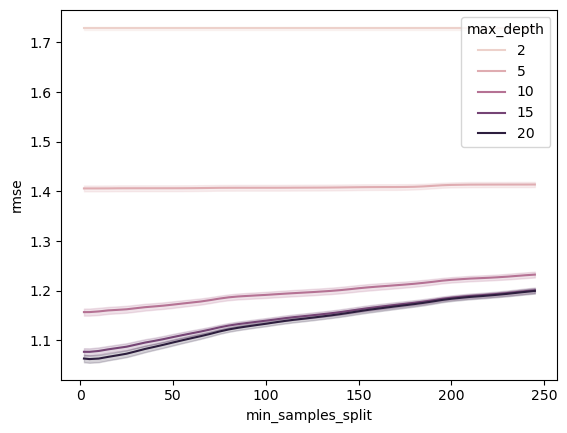

In [168]:
import seaborn as sns

fold_scores = []
for i in range(5):
    fold_scores.append(-results[f'split{i}_test_score'])
    
df = pd.DataFrame(params)
for i, fold_score in enumerate(fold_scores):
    df[f'fold_{i}'] = fold_score

df_melted = df.melt(id_vars=['max_depth', 'min_samples_split'], var_name='fold', value_name='rmse')

sns.lineplot(x='min_samples_split', y='rmse', hue='max_depth', data=df_melted, errorbar='se')

print("Best Hyperparameters:", rf_cv.best_params_)

In [234]:
learn.dtypes

target                       float64
PRIMARY_KEY                    int64
sex                            int64
JOB_42                         int64
studying                       int64
age_2020                       int64
HOUSEHOLD_TYPE                 int64
act_num                        int64
HIGHEST_CREDENTIAL_num         int64
emp_contract                   int64
Pay                            int64
REG_FORMER                     int64
Sports_Category                int64
TYPE_OF_CONTRACT               int64
WORK_CONDITION                 int64
labor_force_status             int64
WORKING_HOURS                  int64
REG_JOB                        int64
Economic_sector_num            int64
work_description               int64
retirement_age_cat             int64
Employer_category_encoded      int64
employee_count_encoded         int64
Encoded_emp_contract           int64
dtype: object

In [183]:
y_test_pred = rf_cv.predict(X_test)

print("RMSE on the learning set:", root_mean_squared_error(Y_train, rf_cv.predict(X_train)))
print("RMSE on the test set:", root_mean_squared_error(Y_test, rf_cv.predict(X_test)))

RMSE on the learning set: 0.609688950471318
RMSE on the test set: 1.0412504191527154


In [ ]:
cv_results = pd.DataFrame(dt_cv.cv_results_)
sns.lineplot(x="param_max_depth", y="mean_test_score", data=cv_results, marker='o', label="Mean Test Score (Negative MSE)")
plt.title("Cross-Validation Results")
plt.xlabel("Max Depth")
plt.ylabel("Mean Test Score (Negative MSE)")
plt.show()

In [137]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, Y_train)

cross_val_rmse = cross_val_score(rf, X_train, Y_train, cv=5, scoring='neg_root_mean_squared_error')

In [144]:
y_test_pred = rf.predict(X_test)

rmse_test = root_mean_squared_error(Y_test, y_test_pred)

print("RMSE on the learning set:", -cross_val_rmse.mean())
print("RMSE on the test set: ", rmse_test)

RMSE on the learning set: 1.0538144449252926
RMSE on the test set:  1.0435643545440383


In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.show()

In [ ]:
cv_results = pd.DataFrame(dt_cv.cv_results_)
sns.lineplot(x="param_max_depth", y="mean_test_score", data=cv_results, marker='o', label="Mean Test Score (Negative MSE)")
plt.title("Cross-Validation Results")
plt.xlabel("Max Depth")
plt.ylabel("Mean Test Score (Negative MSE)")
plt.show()

# Pipeline

In [180]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np

# Define a function to handle the imputation
def impute_working_hours_and_pay(learn_data):
    avg_working_hours = learn_data.loc[learn_data["WORKING_HOURS"] != 0].groupby("JOB_42")["WORKING_HOURS"].mean().round()
    avg_pay = learn_data.loc[learn_data["Pay"] != 0].groupby("JOB_42")["Pay"].mean().round()

    learn_data["WORKING_HOURS"] = learn_data.apply(
        lambda row: avg_working_hours.get(row["JOB_42"], np.nan) if pd.isnull(row["WORKING_HOURS"]) else row["WORKING_HOURS"],
        axis=1
    )
    learn_data["Pay"] = learn_data.apply(
        lambda row: avg_pay.get(row["JOB_42"], np.nan) if pd.isnull(row["Pay"]) else row["Pay"],
        axis=1
    )
    return learn_data

# Define a custom transformer for the pipeline
class ImputeMissingValues:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return impute_working_hours_and_pay(X)

# Define your pipeline
pipeline = Pipeline([
    ('imputer', ImputeMissingValues()),
    # Add other steps here, e.g., model training, scaling, etc.
])


#need to add the one that we find on the internet 
#do the same for the MICE algo 

In [182]:
# Apply the pipeline to your training dataset
train_data = pipeline.fit_transform(learn_data)
train_data

# Apply the same pipeline to your test dataset
#test_data = pipeline.transform(test_data)

,target,PRIMARY_KEY,sex,JOB_42,studying,INSEE_CODE,age_2020,HOUSEHOLD_TYPE,act_num,HIGHEST_CREDENTIAL_num,...,Employer_category,employee_count,TYPE_OF_CONTRACT,WORK_CONDITION,labor_force_status,WORKING_HOURS,REG_JOB,Economic_sector_num,work_description,retirement_age_cat
0,9.367020,1,0,csp_5_4,0,01004,34,3,1,10,...,9,1,CDI,C,O,1470.0,84,7,5,Employed_Missing
1,8.648771,5,1,csp_6_3,0,01004,80,7,3,6,...,9,1,CDI,C,O,793.0,44,4,6,60
2,10.792503,7,0,csp_3_1,0,01004,63,4,1,11,...,0,0,Employed_Missing,Employed_Missing,Employed_Missing,1241.0,Employed_Missing,Employed_Missing,Employed_Missing,Employed_Missing
3,8.508222,8,1,csp_3_7,0,01004,50,4,1,9,...,9,1,CDI,C,O,1201.0,11,2,3,Employed_Missing
4,8.966272,10,0,csp_5_6,0,01004,68,7,2,6,...,10,7,Unemployed,Unemployed,Unemployed,0.0,Unemployed,Unemployed,Unemployed,Unemployed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50038,11.154438,100077,0,csp_8_5,1,95680,29,5,6,6,...,10,7,Unemployed,Unemployed,Unemployed,0.0,Unemployed,Unemployed,Unemployed,Unemployed
50039,9.962345,100078,0,csp_4_3,0,95680,34,4,1,9,...,8,6,CDI,P,O,665.0,11,9,4,Employed_Missing
50040,12.226288,100079,0,csp_5_2,0,95680,29,6,1,8,...,8,4,CDI,C,O,3000.0,11,9,5,Employed_Missing
50041,8.965529,100081,1,csp_8_5,0,95680,57,3,7,6,...,10,7,Unemployed,Unemployed,Unemployed,0.0,Unemployed,Unemployed,Unemployed,Unemployed


In [186]:
from sklearn.pipeline import Pipeline
from sklearn.impute import IterativeImputer
import pandas as pd

# Define your custom transformer for MICE imputation
class MICEImputer:
    def __init__(self, columns_to_impute):
        self.columns_to_impute = columns_to_impute
        self.imputer = IterativeImputer(random_state=100)
        
    def fit(self, X, y=None):
        # Fit the imputer only on the specified columns
        self.imputer.fit(X[self.columns_to_impute])
        return self
    
    def transform(self, X):
        # Transform only the specified columns
        X_imputed = X.copy()
        X_imputed[self.columns_to_impute] = self.imputer.transform(X[self.columns_to_impute])
        return X_imputed

# Columns to impute
columns_to_impute = ["Employer_category", "employee_count"]  # Specify the columns that need imputation

# Define the pipeline
pipeline = Pipeline([
    ('mice_imputer', MICEImputer(columns_to_impute=columns_to_impute)),
    # You can add more steps here like encoding, scaling, etc.
])



# Now, you can apply the same pipeline on the test set
#df_test_imputed = pipeline.transform(df_test_1)


In [195]:
# Fit and transform the training data
learn_data_imputed = pipeline.fit_transform(train_data)

# After imputing, you can handle the rounded transformation for 'employee_count_encoded'
learn_data_imputed["employee_count_encoded"] = learn_data_imputed["employee_count"].round().astype(int)
learn_data_imputed

,target,PRIMARY_KEY,sex,JOB_42,studying,INSEE_CODE,age_2020,HOUSEHOLD_TYPE,act_num,HIGHEST_CREDENTIAL_num,...,employee_count,TYPE_OF_CONTRACT,WORK_CONDITION,labor_force_status,WORKING_HOURS,REG_JOB,Economic_sector_num,work_description,retirement_age_cat,employee_count_encoded
0,9.367020,1,0,csp_5_4,0,01004,34,3,1,10,...,1.0,CDI,C,O,1470.0,84,7,5,Employed_Missing,1
1,8.648771,5,1,csp_6_3,0,01004,80,7,3,6,...,1.0,CDI,C,O,793.0,44,4,6,60,1
2,10.792503,7,0,csp_3_1,0,01004,63,4,1,11,...,0.0,Employed_Missing,Employed_Missing,Employed_Missing,1241.0,Employed_Missing,Employed_Missing,Employed_Missing,Employed_Missing,0
3,8.508222,8,1,csp_3_7,0,01004,50,4,1,9,...,1.0,CDI,C,O,1201.0,11,2,3,Employed_Missing,1
4,8.966272,10,0,csp_5_6,0,01004,68,7,2,6,...,7.0,Unemployed,Unemployed,Unemployed,0.0,Unemployed,Unemployed,Unemployed,Unemployed,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50038,11.154438,100077,0,csp_8_5,1,95680,29,5,6,6,...,7.0,Unemployed,Unemployed,Unemployed,0.0,Unemployed,Unemployed,Unemployed,Unemployed,7
50039,9.962345,100078,0,csp_4_3,0,95680,34,4,1,9,...,6.0,CDI,P,O,665.0,11,9,4,Employed_Missing,6
50040,12.226288,100079,0,csp_5_2,0,95680,29,6,1,8,...,4.0,CDI,C,O,3000.0,11,9,5,Employed_Missing,4
50041,8.965529,100081,1,csp_8_5,0,95680,57,3,7,6,...,7.0,Unemployed,Unemployed,Unemployed,0.0,Unemployed,Unemployed,Unemployed,Unemployed,7


In [396]:
learn_data.dtypes

target                     float64
PRIMARY_KEY                  int64
sex                          int64
JOB_42                      object
studying                     int64
INSEE_CODE                  object
age_2020                     int64
HOUSEHOLD_TYPE               int64
act_num                      int64
HIGHEST_CREDENTIAL_num       int64
RESIDENTS                    int64
Lat                        float64
long                       float64
emp_contract              category
Pay                          Int64
REG_FORMER                category
Sports_Category              int64
Employer_category            int64
employee_count               int64
TYPE_OF_CONTRACT          category
WORK_CONDITION            category
labor_force_status        category
WORKING_HOURS                Int64
REG_JOB                   category
Economic_sector_num       category
work_description          category
retirement_age_cat        category
dtype: object

# Run from here

In [596]:
#df_train_imputed.dtypes

## more formatting

In [49]:
learn_rf = learn_data
learn_rf = learn_rf.sort_values(by='JOB_42', ascending=False)
learn_rf["JOB_42"] = pd.factorize(learn_rf["JOB_42"])[0]

learn_rf = learn_rf.sort_values(by='REG_JOB', ascending=False)
learn_rf["REG_JOB"] = pd.factorize(learn_rf["REG_JOB"])[0]

learn_rf = learn_rf.sort_values(by='Economic_sector_num', ascending=False)
learn_rf["Economic_sector_num"] = pd.factorize(learn_rf["Economic_sector_num"])[0]

learn_rf = learn_rf.sort_values(by='work_description', ascending=False)
learn_rf["work_description"] = pd.factorize(learn_rf["work_description"])[0]

learn_rf = learn_rf.sort_values(by='retirement_age_cat', ascending=False)
learn_rf["retirement_age_cat"] = pd.factorize(learn_rf["retirement_age_cat"])[0]

learn_rf = learn_rf.sort_values(by='REG_FORMER', ascending=False)
learn_rf["REG_FORMER"] = pd.factorize(learn_rf["REG_FORMER"])[0]

learn_rf = learn_rf.sort_values(by='TYPE_OF_CONTRACT', ascending=False)
learn_rf["TYPE_OF_CONTRACT"] = pd.factorize(learn_rf["TYPE_OF_CONTRACT"])[0]

learn_rf = learn_rf.sort_values(by='WORK_CONDITION', ascending=False)
learn_rf["WORK_CONDITION"] = pd.factorize(learn_rf["WORK_CONDITION"])[0]

learn_rf = learn_rf.sort_values(by='labor_force_status', ascending=False)
learn_rf["labor_force_status"] = pd.factorize(learn_rf["labor_force_status"])[0]

learn_rf = learn_rf.sort_values(by='emp_contract', ascending=False)
learn_rf["emp_contract"] = pd.factorize(learn_rf["emp_contract"])[0]

learn_rf = learn_rf.sort_values(by='PRIMARY_KEY', ascending=True)

In [51]:
learn_rf.drop(["Lat", "long", "RESIDENTS", "INSEE_CODE"], axis=1, inplace=True)

In [53]:
learn_rf

,target,PRIMARY_KEY,sex,JOB_42,studying,age_2020,HOUSEHOLD_TYPE,act_num,HIGHEST_CREDENTIAL_num,emp_contract,...,Employer_category,employee_count,TYPE_OF_CONTRACT,WORK_CONDITION,labor_force_status,WORKING_HOURS,REG_JOB,Economic_sector_num,work_description,retirement_age_cat
0,9.367020,1,0,13,0,34,3,1,10,4,...,9,1,5,5,4,1470,5,6,4,0
1,8.648771,5,1,9,0,80,7,3,6,4,...,9,1,5,5,4,793,10,9,3,6
2,10.792503,7,0,28,0,63,4,1,11,2,...,0,0,0,0,0,<NA>,0,0,0,0
3,8.508222,8,1,24,0,50,4,1,9,4,...,9,1,5,5,4,1201,15,11,6,0
4,8.966272,10,0,11,0,68,7,2,6,0,...,10,7,2,2,2,0,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50038,11.154438,100077,0,1,1,29,5,6,6,0,...,10,7,2,2,2,0,2,2,2,1
50039,9.962345,100078,0,21,0,34,4,1,9,4,...,8,6,5,3,4,665,15,4,5,0
50040,12.226288,100079,0,15,0,29,6,1,8,4,...,8,4,5,5,4,3000,15,4,4,0
50041,8.965529,100081,1,1,0,57,3,7,6,0,...,10,7,2,2,2,0,2,2,2,1


## pipeline

In [117]:
from sklearn.pipeline import Pipeline
from sklearn.impute import IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np


x_train = learn_rf.drop(columns=["target"])
y_train = learn_rf["target"]

X_train, X_test, Y_train, Y_test = train_test_split(x_train,
                                                    y_train, 
                                                    test_size=0.3, 
                                                    random_state=42)

# Custom Transformer for Handling Imputation with Averages
class ImputeMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Calculate averages for training data (ignoring zero values)
        self.avg_working_hours = X.loc[X["WORKING_HOURS"] != 0].groupby("JOB_42")["WORKING_HOURS"].mean().round()
        self.avg_pay = X.loc[X["Pay"] != 0].groupby("JOB_42")["Pay"].mean().round()
        return self

    def transform(self, X, y=None):
        # Use the stored averages to impute missing values
        X = X.copy()
        X["WORKING_HOURS"] = X.apply(
            lambda row: self.avg_working_hours.get(row["JOB_42"], np.nan) 
            if pd.isnull(row["WORKING_HOURS"]) else row["WORKING_HOURS"],
            axis=1
        )
        X["Pay"] = X.apply(
            lambda row: self.avg_pay.get(row["JOB_42"], np.nan) 
            if pd.isnull(row["Pay"]) else row["Pay"],
            axis=1
        )
        return X


# Custom Transformer for MICE (Multiple Imputation by Chained Equations) Imputation
class MICEImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_impute):
        self.columns_to_impute = columns_to_impute
        self.imputer = IterativeImputer(random_state=100)
        
    def fit(self, X, y=None):
        # Fit the imputer only on the specified columns
        self.imputer.fit(X[self.columns_to_impute])
        return self
    
    def transform(self, X):
        # Transform only the specified columns
        X_imputed = X.copy()
        X_imputed[self.columns_to_impute] = self.imputer.transform(X[self.columns_to_impute])
        return X_imputed


# Specify the columns that need MICE imputation
columns_to_impute = ["Employer_category", "employee_count"]

# Define the combined pipeline
pipeline = Pipeline([
    ('impute_averages', ImputeMissingValues()),  # Step 1: Impute using averages
    ('mice_imputer', MICEImputer(columns_to_impute=columns_to_impute)),  # Step 2: MICE imputation
])

pipeline.fit(X_train, Y_train)

Pipeline(steps=[('impute_averages', ImputeMissingValues()),
                ('mice_imputer',
                 MICEImputer(columns_to_impute=['Employer_category',
                                                'employee_count']))])

In [119]:
param_grid_rf = {     # Number of trees in the forest
    'max_depth': [None, 5, 10, 30],    
    'min_samples_split': [5, 10, 20]  
}

# Define cross-validation with 5 folds
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)

# Set up the GridSearchCV for RandomForestRegressor with appropriate scoring metric
rf_search = GridSearchCV(rf, param_grid_rf, cv=cv_folds, n_jobs=-1, scoring="neg_mean_squared_error")

In [121]:
# Fit the model on the training data
rf_res = rf_search.fit(X_train, Y_train)

In [122]:
# Get the best model after GridSearchCV
best_model_rf = rf_res.best_estimator_

# Output the best model and its score
print(f"Best model: {best_model_rf}")
print(f"Best score: {rf_res.best_score_}")

Best model: RandomForestRegressor(max_depth=30, min_samples_split=10, random_state=42)
Best score: -1.123680174829581


In [123]:
from sklearn.metrics import r2_score

train_predictions = best_model_rf.predict(X_train)
test_predictions = best_model_rf.predict(X_test)

# Calculate R²
train_r2 = r2_score(Y_train, train_predictions)
test_r2 = r2_score(Y_test, test_predictions)

print(f"R² for training set: {train_r2}")
print(f"R² for test set: {test_r2}")
print("RMSE on the learning set:", root_mean_squared_error(Y_train, best_model_rf.predict(X_train)))
print("RMSE on the test set:", root_mean_squared_error(Y_test, best_model_rf.predict(X_test)))

R² for training set: 0.9103951214641673
R² for test set: 0.744872114446291
RMSE on the learning set: 0.6153975354423522
RMSE on the test set: 1.0444475308257197


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


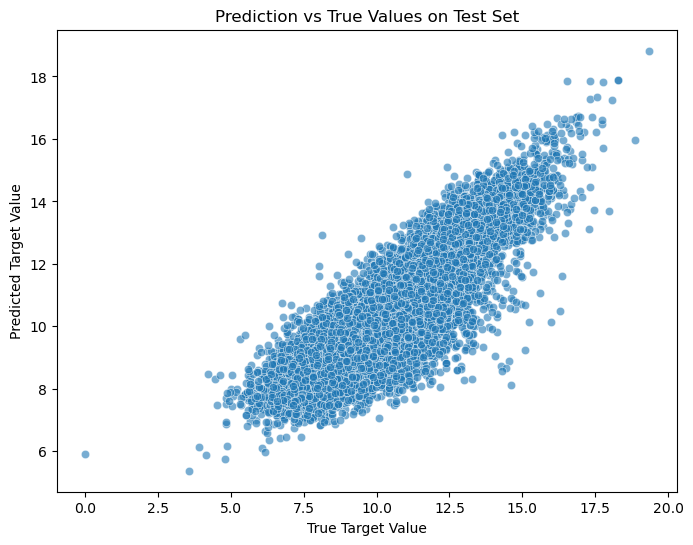

In [124]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=test_predictions, alpha=0.6)
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.show()

## test data!

In [141]:
test = pd.read_csv("test2.csv")

In [143]:
test = test.sort_values(by='JOB_42', ascending=False)
test["JOB_42"] = pd.factorize(test["JOB_42"])[0]

test = test.sort_values(by='REG_JOB', ascending=False)
test["REG_JOB"] = pd.factorize(test["REG_JOB"])[0]

test = test.sort_values(by='Economic_sector_num', ascending=False)
test["Economic_sector_num"] = pd.factorize(test["Economic_sector_num"])[0]

test = test.sort_values(by='work_description', ascending=False)
test["work_description"] = pd.factorize(test["work_description"])[0]

test = test.sort_values(by='retirement_age_cat', ascending=False)
test["retirement_age_cat"] = pd.factorize(test["retirement_age_cat"])[0]

test = test.sort_values(by='REG_FORMER', ascending=False)
test["REG_FORMER"] = pd.factorize(test["REG_FORMER"])[0]

test = test.sort_values(by='TYPE_OF_CONTRACT', ascending=False)
test["TYPE_OF_CONTRACT"] = pd.factorize(test["TYPE_OF_CONTRACT"])[0]

test = test.sort_values(by='WORK_CONDITION', ascending=False)
test["WORK_CONDITION"] = pd.factorize(test["WORK_CONDITION"])[0]

test = test.sort_values(by='labor_force_status', ascending=False)
test["labor_force_status"] = pd.factorize(test["labor_force_status"])[0]

test = test.sort_values(by='emp_contract', ascending=False)
test["emp_contract"] = pd.factorize(test["emp_contract"])[0]

test = test.sort_values(by='PRIMARY_KEY', ascending=True)

In [145]:
test_rf = pipeline.transform(test)

In [147]:
test_predictions = best_model_rf.predict(test_rf)  # Replace with your model's prediction method

# Assuming 'PRIMARY_KEY' is a column in your test set
# Create a DataFrame with PRIMARY_KEY and predicted target values
predictions_df = pd.DataFrame({
    'PRIMARY_KEY': test['PRIMARY_KEY'],  # Replace 'PRIMARY_KEY' with the correct column name
    'target': test_predictions
})

# Save the predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False, sep=',', float_format='%.6f')  # Save with US decimal notation


In [76]:
hhhhh = pd.read_csv("predictions.csv")

In [77]:
hhhhh

,PRIMARY_KEY,target
0,2,9.712317
1,3,10.562816
2,4,9.883677
3,6,12.690809
4,9,9.740105
...,...,...
50035,100071,10.558130
50036,100074,8.717176
50037,100075,9.206181
50038,100080,10.971262


# Ignore

## Random forest fitting

In [473]:
x_train = learn_rf.drop(columns=["target"])
y_train = learn_rf["target"]

X_train, X_test, Y_train, Y_test = train_test_split(x_train,
                                                    y_train, 
                                                    test_size=0.2, 
                                                    random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [507]:
param_grid_rf = {     # Number of trees in the forest
    'max_depth': [None, 5, 10, 30],    
    'min_samples_split': [5, 10, 20]  
}

# Define cross-validation with 5 folds
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)

# Set up the GridSearchCV for RandomForestRegressor with appropriate scoring metric
rf_search = GridSearchCV(rf, param_grid_rf, cv=cv_folds, n_jobs=-1, scoring="neg_mean_squared_error")

In [509]:
# Fit the model on the training data
rf_res = rf_search.fit(X_train, Y_train)

In [510]:
results = rf_res.cv_results_
params = results['params']

### ignore

### prediction

In [523]:
# Get the best model after GridSearchCV
best_model_rf = rf_search.best_estimator_

# Output the best model and its score
print(f"Best model: {best_model_rf}")
print(f"Best score: {rf_search.best_score_}")

Best model: RandomForestRegressor(min_samples_split=5, random_state=42)
Best score: -1.107334027542731


In [525]:
y_test_pred = best_model_rf.predict(X_test)

print("RMSE on the learning set:", root_mean_squared_error(Y_train, best_model_rf.predict(X_train)))
print("RMSE on the test set:", root_mean_squared_error(Y_test, best_model_rf.predict(X_test)))

RMSE on the learning set: 0.47742921718835685
RMSE on the test set: 1.018520237789917


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


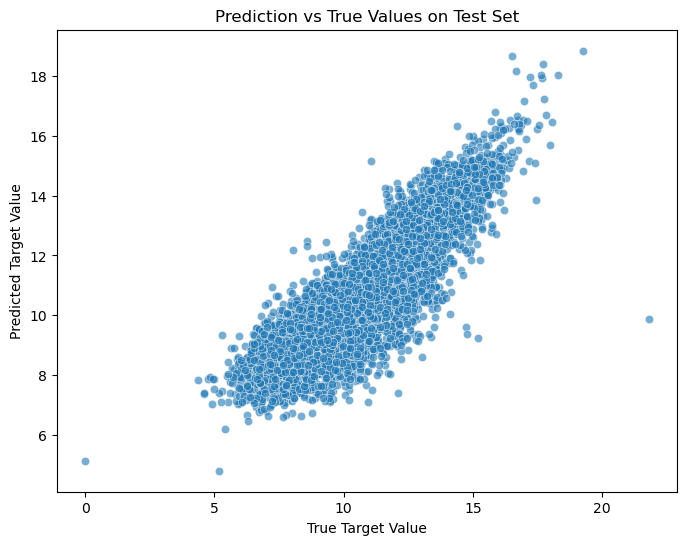

In [526]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.show()

In [527]:
from sklearn.metrics import r2_score

train_predictions = best_model_rf.predict(X_train)

# Predict on the test data
test_predictions = best_model_rf.predict(X_test)

# Calculate R² for the training set
train_r2 = r2_score(Y_train, train_predictions)

# Calculate R² for the test set
test_r2 = r2_score(Y_test, test_predictions)

# Print the results
print(f"R² for training set: {train_r2}")
print(f"R² for test set: {test_r2}")


print("RMSE on the learning set:", root_mean_squared_error(Y_train, best_model_rf.predict(X_train)))
print("RMSE on the test set:", root_mean_squared_error(Y_test, best_model_rf.predict(X_test)))

R² for training set: 0.9462319904499941
R² for test set: 0.7558644753423779
RMSE on the learning set: 0.47742921718835685
RMSE on the test set: 1.018520237789917


## formatting csv

In [652]:
X_eval = test
test_predictions = best_model_rf.predict(X_eval)  # Replace with your model's prediction method

# Assuming 'PRIMARY_KEY' is a column in your test set
# Create a DataFrame with PRIMARY_KEY and predicted target values
predictions_df = pd.DataFrame({
    'PRIMARY_KEY': X_eval['PRIMARY_KEY'],  # Replace 'PRIMARY_KEY' with the correct column name
    'target': test_predictions
})

# Save the predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False, sep=',', float_format='%.6f')  # Save with US decimal notation


In [654]:
predictions_df

,PRIMARY_KEY,target
40683,81146,14.615536
25504,50695,14.043586
4907,9661,13.040633
4924,9693,10.371201
4653,9180,11.425176
...,...,...
38578,76983,11.874532
6148,12131,12.955167
2454,4800,13.813388
33579,66917,11.731783
